In [2]:
import itertools
import dgl
import networkx as nx
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

from dgllife.utils import mol_to_bigraph
from dgllife.utils import BaseAtomFeaturizer, BaseBondFeaturizer
from dgllife.utils.featurizers import (atom_chiral_tag_one_hot,
                                       atom_chirality_type_one_hot,
                                       atom_degree_one_hot,
                                       atom_explicit_valence_one_hot,
                                       atom_formal_charge_one_hot,
                                       atom_hybridization_one_hot,
                                       atom_implicit_valence_one_hot,
                                       atom_is_aromatic_one_hot,
                                       atom_is_chiral_center,
                                       atom_is_in_ring_one_hot,
                                       atom_mass,
                                       atom_num_radical_electrons_one_hot,
                                       atom_total_num_H_one_hot,
                                       atom_type_one_hot,
                                       atomic_number,
                                       bond_is_conjugated_one_hot,
                                       bond_is_in_ring,
                                       bond_type_one_hot)
from torch import tensor
from IPython.display import SVG

rdDepictor.SetPreferCoordGen(True)

ATOM_FEATURIZER = BaseAtomFeaturizer({'atom_type': atom_type_one_hot,
                                      'atomic_number': atomic_number,
                                      'atom_mass': atom_mass,
                                      'atom_degree': atom_degree_one_hot,
                                      'atom_explicit': atom_explicit_valence_one_hot,
                                      'atom_implicit': atom_implicit_valence_one_hot,
                                      'atom_num_H': atom_total_num_H_one_hot,
                                      'formal_charge': atom_formal_charge_one_hot,
                                      'atom_hybridization': atom_hybridization_one_hot,
                                      'radical_e': atom_num_radical_electrons_one_hot,
                                      'aromatic': atom_is_aromatic_one_hot,
                                      'atom_in_ring': atom_is_in_ring_one_hot,
                                      'atom_chiral_tag': atom_chiral_tag_one_hot,
                                      'atom_chirality': atom_chirality_type_one_hot,
                                      'atom_chiral_center': atom_is_chiral_center})

BOND_FEATURIZER = BaseBondFeaturizer({'bond_type': bond_type_one_hot,
                                      'in_ring': bond_is_in_ring,
                                      'conj_bond': bond_is_conjugated_one_hot})

NODE_ATTRS = ['atom_type',
              'atomic_number',
              'atom_mass',
              'atom_degree',
              'atom_explicit',
              'atom_implicit',
              'atom_num_H',
              'formal_charge',
              'atom_hybridization',
              'radical_e',
              'aromatic',
              'atom_in_ring',
              'atom_chiral_tag',
              'atom_chirality',
              'atom_chiral_center']

EDGE_ATTRS = ['bond_type',
              'in_ring',
              'conj_bond']

"""
Separate atoms into element groups, cyclics and non cyclics
这段代码的目标是将原子分成不同的元素组、环和非环部分。在代码中，给定了几种不同的元素（碳、氮、氧、磷、硫）和它们的原子编号（原子数）。
"""
carbon_atnum = tensor([6.])
nitrogen_atnum = tensor([7.])
oxygen_atnum = tensor([8.])
phosphorus_atnum = tensor([15.])
sulfur_atnum = tensor([16.])

# chemical bonds
single_bond = list(tensor([1., 0., 0., 0.]))
double_bond = list(tensor([0., 1., 0., 0.]))
triple_bond = list(tensor([0., 0., 1., 0.]))

In [3]:
def atom_groups(G):
    "get all atoms in atom groups"
    '''carbons第i条数据保存第i个分子中的所有碳原子'''
    carbons = []
    nitrogens = []
    sulfurs = []
    oxygens = []
    phosphorus = []

    for i in range(len(G)):
        node_list_i = list(G[i].nodes())
        carbons_i = []
        nitrogens_i = []
        sulfurs_i = []
        oxygens_i = []
        phosphorus_i = []
        for node_i in node_list_i:
            # 按原子序数给原子分组
            if nx.get_node_attributes(G[i], 'atomic_number')[node_i] == carbon_atnum:
                carbons_i.append(node_i)
            elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == nitrogen_atnum:
                nitrogens_i.append(node_i)
            elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == sulfur_atnum:
                sulfurs_i.append(node_i)
            elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == oxygen_atnum:
                oxygens_i.append(node_i)
            elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == phosphorus_atnum:
                phosphorus_i.append(node_i)
        carbons.append(carbons_i)
        nitrogens.append(nitrogens_i)
        sulfurs.append(sulfurs_i)
        oxygens.append(oxygens_i)
        phosphorus.append(phosphorus_i)

    return carbons, nitrogens, sulfurs, oxygens, phosphorus

In [4]:
def cyclic_atoms(G, edge_name=None):
    '''从给定的多个图中找到所有的环和与环相关联的节点和边'''
    cycle_list = []  # nodes in cycles separated by list
    edges_in_cycle = []  # edges between nodes in cycles
    nodes_in_cycle = []  # all nodes in cycles

    for i in range(len(G)):
        cycle_list_i = []  # nodes in cycle for each molecule
        edges_in_cycle_i = []
        for cycle_idx_i, nodes_in_cycle_list_i in enumerate(nx.cycle_basis(G[i])):
            "get nodes in cycles (cycle by cycle)"
            cycle_list_i.append(nodes_in_cycle_list_i)  # cycle list for each molecule

            "get edges between nodes in cycle"
            for j in range(len(cycle_list_i)):
                for k in range(len(cycle_list_i[j])):
                    if G[i].has_edge(cycle_list_i[j][k], cycle_list_i[j][k - 1]) == True:
                        edge_in_cycle_j = [cycle_list_i[j][k], cycle_list_i[j][k - 1]]
                        edge_in_cycle_j.sort()
                        edges_in_cycle_i.append(edge_in_cycle_j)
                        edges_in_cycle_i.sort()
                        edges_in_cycle_i = list(
                            edges_in_cycle_i for edges_in_cycle_i, _ in itertools.groupby(edges_in_cycle_i))

        edges_in_cycle.append(edges_in_cycle_i)
        cycle_list.append(cycle_list_i)  # cycle list for whole dataset

        "all nodes in cycles"
        nodes_in_cycle_i = []  # nodes in cycle for each molecule
        for sublist in cycle_list[i]:
            for item in sublist:
                nodes_in_cycle_i.append(item)
                nodes_in_cycle_i = list(dict.fromkeys(nodes_in_cycle_i))
        nodes_in_cycle.append(nodes_in_cycle_i)

    return cycle_list, edges_in_cycle, nodes_in_cycle

In [5]:
def noncyc_atoms(G):
    "get nodes not in cycles"
    (cycle_list, edges_in_cycle, nodes_in_cycle) = cyclic_atoms(G)
    noncyc_carbons = []
    noncyc_nitrogens = []
    noncyc_sulfurs = []
    noncyc_oxygens = []
    noncyc_phosphorus = []

    for i in range(len(G)):
        node_list_i = list(G[i].nodes())
        noncyc_carbons_i = []
        noncyc_nitrogens_i = []
        noncyc_sulfurs_i = []
        noncyc_oxygens_i = []
        noncyc_phosphorus_i = []

        for node_i in node_list_i:
            if node_i not in nodes_in_cycle[i]:
                if nx.get_node_attributes(G[i], 'atomic_number')[node_i] == carbon_atnum:
                    noncyc_carbons_i.append(node_i)
                elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == nitrogen_atnum:
                    noncyc_nitrogens_i.append(node_i)
                elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == sulfur_atnum:
                    noncyc_sulfurs_i.append(node_i)
                elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == oxygen_atnum:
                    noncyc_oxygens_i.append(node_i)
                elif nx.get_node_attributes(G[i], 'atomic_number')[node_i] == phosphorus_atnum:
                    noncyc_phosphorus_i.append(node_i)

        noncyc_carbons.append(noncyc_carbons_i)
        noncyc_nitrogens.append(noncyc_nitrogens_i)
        noncyc_sulfurs.append(noncyc_sulfurs_i)
        noncyc_oxygens.append(noncyc_oxygens_i)
        noncyc_phosphorus.append(noncyc_phosphorus_i)

    return noncyc_carbons, noncyc_nitrogens, noncyc_sulfurs, noncyc_oxygens, noncyc_phosphorus

In [6]:
def func_groups(G):
    alkene = []
    alkyne = []
    allene = []
    carboxyl = []  # 1, 2, 9,fo
    ketene = []
    alcohol = []  # 2, 5, 12
    ketone = []  # 1, 35
    aldehyde = []
    ether = []  # 1, 2
    peroxide = []
    carbamate = []

    thioether = []
    disulfide = []  # 5, 11, 32
    sulfone = []
    thioamide = []
    thiourea = []
    thiol = []
    thione = []
    sulfoxide = []
    isothiocynate = []
    sulfonamide = []
    sulfonate = []

    amine = []  # 5, 11, 19
    amide = []  # 25, 35
    imine = []
    carbamide = []  # 23
    hydrazine = []
    nitrile = []
    hydrazone = []
    azo = []  # 23
    isocynate = []
    nitro = []  # 6, 20
    carbodiimide = []
    oxime = []
    c_nitroso = []
    hydroamine = []
    carboximidamide = []

    phosphorus_grps = []
    (carbons, nitrogens, sulfurs, oxygens, phosphorus) = atom_groups(G)
    (noncyc_carbons, noncyc_nitrogens, noncyc_sulfurs, noncyc_oxygens, noncyc_phosphorus) = noncyc_atoms(G)

    for i in range(len(G)):
        carboxyl_i = []
        carbamate_i = []
        carbamide_i = []
        amide_i = []
        ketone_i = []
        aldehyde_i = []
        ketene_i = []
        isocynate_i = []
        isothiocynate_i = []
        thione_i = []
        thioamide_i = []
        thiourea_i = []
        oxime_i = []
        hydrazone_i = []
        carboximidamide_i = []
        imine_i = []
        carbodiimide_i = []
        alcohol_i = []
        thiol_i = []
        allene_i = []
        alkyne_i = []
        ether_i = []
        peroxide_i = []
        thioether_i = []
        sulfoxide_i = []
        sulfone_i = []
        sulfonamide_i = []
        sulfonate_i = []
        disulfide_i = []
        amine_i = []
        nitrile_i = []
        hydrazine_i = []
        azo_i = []
        c_nitroso_i = []
        hydroamine_i = []
        nitro_i = []
        phosphorus_grps_i = []
        alkene_i = []

        "C as the central atom"
        for node_i in carbons[i]:
            neighbors_i = list(G[i].neighbors(node_i))  # neighbors of central atom

            # for molecules with C=O
            if (True in (((list(G[i][node_i][neighbor_i]['bond_type']) == double_bond) and (
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum)) for neighbor_i in
                         neighbors_i)):
                "C double bonded to O"
                if len([neighbor_i for neighbor_i in neighbors_i if
                        nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 2:
                    "C bonded to two Os"
                    if (([neighbor_i for neighbor_i in neighbors_i if
                          nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) and (
                            [neighbor_i for neighbor_i in neighbors_i if
                             list(G[i][node_i][neighbor_i]['bond_type']) == single_bond])):
                        "C single-bonded to C"
                        "-COO-"
                        for neighbor_i in neighbors_i:
                            if ((list(G[i][node_i][neighbor_i]['bond_type']) == single_bond) and (
                                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum)):
                                "get neighbors of single-bonded O"
                                all_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_neighbors_i))
                        carboxyl_i.append(nlist)  # carboxyl groups of each molecule

                    elif (([neighbor_i for neighbor_i in neighbors_i if
                            nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) and (
                                  [neighbor_i for neighbor_i in neighbors_i if
                                   list(G[i][node_i][neighbor_i]['bond_type']) == single_bond])):
                        "C single-bonded to N"
                        "meaning C bonded to one N and two Os"
                        "-NCOO-"
                        for neighbor_i in neighbors_i:
                            if ((list(G[i][node_i][neighbor_i]['bond_type']) == single_bond) and (
                                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum)):
                                all_n_neighbors = list(nx.all_neighbors(G[i], neighbor_i))
                        for neighbor_i in neighbors_i:
                            if ((list(G[i][node_i][neighbor_i]['bond_type']) == single_bond) and (
                                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum)):
                                all_o_neighbors = list(nx.all_neighbors(G[i], neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors + all_o_neighbors))
                        carbamate_i.append(nlist)
                elif len([neighbor_i for neighbor_i in neighbors_i if
                          nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 2:
                    "C bonded to two Ns"
                    "-NCON-"
                    all_n_neighbors_i = []
                    for neighbor_i in neighbors_i:
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                            n_neighbor_i = list(nx.all_neighbors(G[i], neighbor_i))
                            for ni, n in enumerate(n_neighbor_i):
                                all_n_neighbors_i.append(n)
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                    carbamide_i.append(nlist)

                elif (len([neighbor_i for neighbor_i in neighbors_i if
                           nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1 and len(
                    [neighbor_i for neighbor_i in neighbors_i if
                     nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1 and len(
                    [neighbor_i for neighbor_i in neighbors_i if
                     nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1):
                    "C bonded to one C and one N and one O"
                    "-NCO-"
                    for neighbor_i in neighbors_i:
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                            all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                    amide_i.append(nlist)

                elif len([neighbor_i for neighbor_i in neighbors_i if
                          nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 2:
                    "C bonded to two Cs"
                    "-CO-"
                    nlist = list(dict.fromkeys([node_i] + neighbors_i))
                    ketone_i.append(nlist)

                elif len(list(G[i].neighbors(node_i))) == 2:
                    if (len([neighbor_i for neighbor_i in neighbors_i if
                             nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1 and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1):
                        "C bonded to one O and one C"
                        if len([neighbor_i for neighbor_i in neighbors_i if
                                list(G[i][node_i][neighbor_i]['bond_type']) == single_bond]) == 1:
                            "-C=O"
                            nlist = list(dict.fromkeys([node_i] + neighbors_i))
                            aldehyde_i.append(nlist)

                        elif len([neighbor_i for neighbor_i in neighbors_i if
                                  list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 2:
                            "-C=C=O"
                            if [neighbor_i for neighbor_i in neighbors_i if
                                nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]:
                                for neighbor_i in neighbors_i:
                                    c_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                            nlist = list(dict.fromkeys([node_i] + neighbors_i + c_neighbors_i))
                            ketene_i.append(nlist)

                    elif (len([neighbor_i for neighbor_i in neighbors_i if
                               nx.get_node_attributes(G[i], 'atomic_number')[
                                   neighbor_i] == nitrogen_atnum]) == 1 and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1):
                        "C bonded to one N and one O"
                        "-N=C=O"
                        if [neighbor_i for neighbor_i in neighbors_i if
                            nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]:
                            for neighbor_i in neighbors_i:
                                all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                        isocynate_i.append(nlist)

            # for molecules with C=S
            elif (True in (((list(G[i][node_i][neighbor_i]['bond_type']) == double_bond) and (
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == sulfur_atnum)) for neighbor_i in
                           neighbors_i)):
                "C is double bonded to one S"
                "C=S"
                if len(list(G[i].neighbors(node_i))) == 2:
                    if (len([neighbor_i for neighbor_i in neighbors_i if
                             nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == sulfur_atnum]) == 1 and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1):
                        "C bonded to one S and one N"
                        if [neighbor_i for neighbor_i in neighbors_i if
                            nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]:
                            for neighbor_i in neighbors_i:
                                all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                        isothiocynate_i.append(nlist)

                elif len(list(G[i].neighbors(node_i))) == 3:
                    if len([neighbor_i for neighbor_i in neighbors_i if
                            nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 2:
                        "C bonded to two Cs"
                        "-CS-"
                        nlist = list(dict.fromkeys([node_i] + neighbors_i))
                        thione_i.append(nlist)

                    elif (len([neighbor_i for neighbor_i in neighbors_i if
                               nx.get_node_attributes(G[i], 'atomic_number')[
                                   neighbor_i] == nitrogen_atnum]) == 1 and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1):
                        "C bonded to one N and one C"
                        "-HN-CS-"
                        for neighbor_i in neighbors_i:
                            if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                                all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                        thioamide_i.append(nlist)

                    elif len([neighbor_i for neighbor_i in neighbors_i if
                              nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 2:
                        "meaning C bonded to two Ns"
                        all_n_neighbors_i = []
                        for neighbor_i in neighbors_i:
                            if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                                n_neighbor_i = list(nx.all_neighbors(G[i], neighbor_i))
                                for ni, n in enumerate(n_neighbor_i):
                                    all_n_neighbors_i.append(n)
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                        thiourea_i.append(nlist)

            # for molecules with C=N
            elif (True in (((list(G[i][node_i][neighbor_i]['bond_type']) == double_bond) and (
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum)) for neighbor_i in
                           neighbors_i)):
                "meaning C is double bonded to N"
                if len([neighbor_i for neighbor_i in neighbors_i if
                        list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 1:
                    "1 double bond"
                    for neighbor_i in neighbors_i:
                        if len([neighbor_i for neighbor_i in neighbors_i if
                                nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1:
                            "meaning C only bonded to one N"
                            if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                                "fishing N out"
                                all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                                for n_neighbor_i in all_n_neighbors_i:
                                    "fishing neighbors of N"
                                    if nx.get_node_attributes(G[i], 'atomic_number')[n_neighbor_i] == oxygen_atnum:
                                        "meaning N bonded to O"
                                        all_c_neighbors_i = list(nx.all_neighbors(G[i], node_i))
                                        all_o_neighbors_i = list(nx.all_neighbors(G[i], n_neighbor_i))
                                        nlist = list(
                                            dict.fromkeys(all_c_neighbors_i + all_n_neighbors_i + all_o_neighbors_i))
                                        oxime_i.append(nlist)
                                    elif nx.get_node_attributes(G[i], 'atomic_number')[n_neighbor_i] == nitrogen_atnum:
                                        "meaning N bonded to N"
                                        all_c_neighbors_i = list(nx.all_neighbors(G[i], node_i))
                                        all_n2_neighbors_i = list(nx.all_neighbors(G[i], n_neighbor_i))
                                        nlist = list(
                                            dict.fromkeys(all_c_neighbors_i + all_n_neighbors_i + all_n2_neighbors_i))
                                        hydrazone_i.append(nlist)
                                    else:
                                        all_c_neighbors_i = list(nx.all_neighbors(G[i], node_i))
                                        nlist = list(dict.fromkeys(all_c_neighbors_i + all_n_neighbors_i))
                                        imine_i.append(nlist)

                        elif len([neighbor_i for neighbor_i in neighbors_i if
                                  nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 3:
                            "meaning C bonded to three Ns"
                            n_neighbors_i = []
                            for j in range(len(neighbors_i)):
                                if nx.get_node_attributes(G[i], 'atomic_number')[neighbors_i[j]] == nitrogen_atnum:
                                    n_neighbor_i = list(nx.all_neighbors(G[i], neighbors_i[j]))
                                    n_neighbors_i.append(n_neighbor_i)
                            all_n_neighbors_i = []
                            for sublist in n_neighbors_i:
                                for n in sublist:
                                    all_n_neighbors_i.append(n)
                            nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                            carboximidamide_i.append(nlist)
                            carboximidamide_i.sort()
                            carboximidamide_i = list(
                                carboximidamide_i for carboximidamide_i, _ in itertools.groupby(carboximidamide_i))

                elif len([neighbor_i for neighbor_i in neighbors_i if
                          list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 2:
                    "2 double bonds"
                    n_neighbors_i = []
                    for j in range(len(neighbors_i)):
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbors_i[j]] == nitrogen_atnum:
                            n_neighbor_i = list(nx.all_neighbors(G[i], neighbors_i[j]))
                            n_neighbors_i.append(n_neighbor_i)
                    all_n_neighbors_i = []
                    for sublist in n_neighbors_i:
                        for n in sublist:
                            all_n_neighbors_i.append(n)
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + all_n_neighbors_i))
                    carbodiimide_i.append(nlist)

            # C single bonded to O (aka OH)in
            elif (True in (((list(G[i][node_i][neighbor_i]['bond_type']) == single_bond) and (
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum)) for neighbor_i in
                           neighbors_i)):
                "meaning C single bonded to one O"
                all_c_neighbors_i = list(nx.all_neighbors(G[i], node_i))
                for c_neighbor_i in all_c_neighbors_i:
                    "fishing neighbors of C"
                    if (nx.get_node_attributes(G[i], 'atomic_number')[c_neighbor_i] == oxygen_atnum) and len(
                            list(G[i].neighbors(c_neighbor_i))) == 1:
                        "meaning C bonded to one O and the O only has one neighbor"
                        "-COH"
                        if len([neighbor_i for neighbor_i in neighbors_i if
                                list(G[i][node_i][c_neighbor_i]['bond_type']) == double_bond]) == 0:
                            "meaning no double bonds between node and neighbors"
                            alcohol_i.append([node_i] + all_c_neighbors_i)


            # C single bonded to S (aka SH)
            elif (True in (((list(G[i][node_i][neighbor_i]['bond_type']) == single_bond) and (
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == sulfur_atnum)) for neighbor_i in
                           neighbors_i)):
                "meaning C single bonded to one S"
                "-CS"
                all_c_neighbors_i = list(nx.all_neighbors(G[i], node_i))
                for c_neighbor_i in all_c_neighbors_i:
                    "fishing neighbors of C"
                    if (True in ((nx.get_node_attributes(G[i], 'atomic_number')[c_neighbor_i] == sulfur_atnum) and len(
                            list(G[i].neighbors(c_neighbor_i))) == 1 for neighbor_i in neighbors_i)):
                        thiol_i.append([node_i] + all_c_neighbors_i)

            # C double bonded to two Cs
            elif (len(neighbors_i) == 2) and (len([neighbor_i for neighbor_i in neighbors_i if list(
                    G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 2) and (len(
                [neighbor_i for neighbor_i in neighbors_i if
                 nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 2):
                "meaning C double bonded to two Cs"
                "-C=C=C-"
                all_c_neighbors_i = []
                for neighbor_i in neighbors_i:
                    c1_neighbors = list(G[i].neighbors(neighbors_i[0]))
                    c2_neighbors = list(G[i].neighbors(neighbors_i[1]))
                    c1_neighbors.remove(node_i)
                    c2_neighbors.remove(node_i)
                    all_c_neighbors_i = c1_neighbors + c2_neighbors
                nlist = list(dict.fromkeys([node_i] + neighbors_i + all_c_neighbors_i))
                allene_i.append(nlist)

            # C triple bond C
            elif (all(nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum for neighbor_i in
                      neighbors_i)) and (len([neighbor_i for neighbor_i in neighbors_i if
                                              list(G[i][node_i][neighbor_i]['bond_type']) == triple_bond]) == 1):
                for neighbor_i in neighbors_i:
                    if list(G[i][node_i][neighbor_i]['bond_type']) == triple_bond:
                        c_neighbor_i = list(G[i].neighbors(neighbor_i))
                nlist = list(dict.fromkeys([node_i] + neighbors_i + c_neighbor_i))
                nlist.sort()
                alkyne_i.append(nlist)
                alkyne_i.sort()
                alkyne_i = list(alkyne_i for alkyne_i, _ in itertools.groupby(alkyne_i))

        # O as main atom in molecule
        for node_i in oxygens[i]:
            neighbors_i = list(G[i].neighbors(node_i))
            if len(neighbors_i) == 2:
                "meaning O only bonded to two atoms"
                c_neighbors_i = []
                all_c_neighbors_i = []
                if len([neighbor_i for neighbor_i in neighbors_i if
                        nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 2:
                    "meaning O bonded to 2 C"
                    c1_neighbors = list(G[i].neighbors(neighbors_i[0]))
                    c2_neighbors = list(G[i].neighbors(neighbors_i[1]))
                    c1_neighbors.remove(node_i)
                    c2_neighbors.remove(node_i)
                    all_c_neighbors_i = c1_neighbors + c2_neighbors
                    if (any(node_i in sl for sl in carboxyl_i)) == False:
                        "makes sure -O- is not from carboxyl group"
                        nlist = list(dict.fromkeys([node_i] + neighbors_i))
                        ether_i.append(nlist)
                    ether_i.sort()
                    ether_i = list(ether_i for ether_i, _ in itertools.groupby(ether_i))

                elif (len([neighbor_i for neighbor_i in neighbors_i if
                           nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1) and len(
                    [neighbor_i for neighbor_i in neighbors_i if
                     nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1:
                    "meaning O bonded to one O and one C"
                    for neighbor_i in neighbors_i:
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum:
                            o_neighbor_i = list(G[i].neighbors(neighbor_i))
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + o_neighbor_i))
                    nlist.sort()
                    peroxide_i.append(nlist)
                    peroxide_i.sort()
                    peroxide_i = list(peroxide_i for peroxide_i, _ in itertools.groupby(peroxide_i))

        # S as main atom in molecule
        for node_i in sulfurs[i]:
            neighbors_i = list(G[i].neighbors(node_i))
            if len([neighbor_i for neighbor_i in neighbors_i if
                    nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 2:
                "meaning S bonded to 2 C"
                if len([neighbor_i for neighbor_i in neighbors_i if
                        nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 0:
                    thioether_i.append([node_i] + neighbors_i)
                elif len([neighbor_i for neighbor_i in neighbors_i if
                          nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1:
                    "S bonded to one O"
                    sulfoxide_i.append([node_i] + neighbors_i)
                elif len([neighbor_i for neighbor_i in neighbors_i if
                          nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 2:
                    "S bonded to two Os"
                    sulfone_i.append([node_i] + neighbors_i)

            elif len([neighbor_i for neighbor_i in neighbors_i if
                      nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1 and len(
                [neighbor_i for neighbor_i in neighbors_i if
                 nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 2 and len(
                [neighbor_i for neighbor_i in neighbors_i if
                 nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1:
                "S bonded to two Os, one C and one N"
                for neighbor_i in neighbors_i:
                    if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                        all_n_neighbors_i = list(nx.all_neighbors(G[i], neighbor_i))
                nlist = list(dict.fromkeys(neighbors_i + all_n_neighbors_i))
                sulfonamide_i.append(nlist)

            elif (len([neighbor_i for neighbor_i in neighbors_i if
                       nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 3) and (len(
                [neighbor_i for neighbor_i in neighbors_i if
                 nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1):
                "meaning S bonded to three Os and one C"
                for neighbor_i in neighbors_i:
                    if (nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum) and (
                            list(G[i][node_i][neighbor_i]['bond_type']) == single_bond):
                        o_neighbor_i = list(G[i].neighbors(neighbor_i))
                nlist = list(dict.fromkeys([node_i] + neighbors_i + o_neighbor_i))
                sulfonate_i.append(nlist)

            elif len(neighbors_i) == 2:
                if (len([neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1) and len(
                    [neighbor_i for neighbor_i in neighbors_i if
                     nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == sulfur_atnum]) == 1:
                    "meaning S bonded to one S and one C"
                    for neighbor_i in neighbors_i:
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == sulfur_atnum:
                            s_neighbor_i = list(G[i].neighbors(neighbor_i))
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + s_neighbor_i))
                    nlist.sort()
                    disulfide_i.append(nlist)
                    disulfide_i.sort()
                    disulfide_i = list(disulfide_i for disulfide_i, _ in itertools.groupby(disulfide_i))

        # N as main atom in molecule
        for node_i in nitrogens[i]:
            neighbors_i = list(G[i].neighbors(node_i))

            if all(nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum for neighbor_i in
                   neighbors_i) and all(
                list(G[i][node_i][neighbor_i]['bond_type']) == single_bond for neighbor_i in neighbors_i):
                "meaning N is only single bonded to C or H"
                if (any(node_i in sl for sl in thioamide_i)) == False and (
                        any(node_i in sl for sl in sulfonamide_i)) == False and (
                        any(node_i in sl for sl in amide_i)) == False and (
                        any(node_i in sl for sl in carbamide_i)) == False and (
                        any(node_i in sl for sl in carbamate_i)) == False:
                    "makes sure that there is no overlap to the other groups"
                    nlist = list(dict.fromkeys([node_i] + neighbors_i))
                    amine_i.append(nlist)

            elif all(nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum for neighbor_i in
                     neighbors_i) and all(
                list(G[i][node_i][neighbor_i]['bond_type']) == triple_bond for neighbor_i in neighbors_i):
                "meaning N triple bonded to C"
                all_c_neighbors_i = []
                c_neighbors_i = [list(G[i].neighbors(neighbor_i)) for neighbor_i in neighbors_i]
                for sublist in c_neighbors_i:
                    for item in sublist:
                        all_c_neighbors_i.append(item)
                nlist = list(dict.fromkeys([node_i] + neighbors_i + all_c_neighbors_i))
                nitrile_i.append(nlist)

            elif len(neighbors_i) == 2:
                if all(list(G[i][node_i][neighbor_i]['bond_type']) == single_bond for neighbor_i in neighbors_i):
                    "meaning N only single bonded to neighbors"
                    if (len([neighbor_i for neighbor_i in neighbors_i if
                             nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1) and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1:
                        "meaning N bonded to one N and one C"
                        for neighbor_i in neighbors_i:
                            if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum:
                                n_neighbor_i = list(G[i].neighbors(neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + n_neighbor_i))
                        nlist.sort()
                        hydrazine_i.append(nlist)
                        hydrazine_i.sort()
                        hydrazine_i = list(hydrazine_i for hydrazine_i, _ in itertools.groupby(hydrazine_i))

                elif len([neighbor_i for neighbor_i in neighbors_i if
                          list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 1:
                    "meaning only one double bond"
                    if (len([neighbor_i for neighbor_i in neighbors_i if
                             nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1) and len(
                        [neighbor_i for neighbor_i in neighbors_i if
                         nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == nitrogen_atnum]) == 1:
                        "meaning N bonded to one N and one C "
                        for neighbor_i in neighbors_i:
                            if list(G[i][node_i][neighbor_i]['bond_type']) == double_bond:
                                n_neighbor_i = list(G[i].neighbors(neighbor_i))
                        nlist = list(dict.fromkeys([node_i] + neighbors_i + n_neighbor_i))
                        nlist.sort()
                        azo_i.append(nlist)
                        azo_i.sort()
                        azo_i = list(azo_i for azo_i, _ in itertools.groupby(azo_i))

                    elif [(nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum and list(
                            G[i][node_i][neighbor_i]['bond_type']) == double_bond) for neighbor_i in neighbors_i]:
                        "meaning N double bonded to O"
                        c_nitroso_i.append([node_i] + neighbors_i)

            elif len([neighbor_i for neighbor_i in neighbors_i if
                      nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 1:
                "meaning N bonded to one O"
                if len([neighbor_i for neighbor_i in neighbors_i if
                        list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 0:
                    "meaning no double bonds"
                    for neighbor_i in neighbors_i:
                        if nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum:
                            all_o_neighbors_i = list(G[i].neighbors(neighbor_i))
                    nlist = list(dict.fromkeys([node_i] + neighbors_i + all_o_neighbors_i))
                    hydroamine_i.append(nlist)

            elif len([neighbor_i for neighbor_i in neighbors_i if
                      nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == oxygen_atnum]) == 2 and len(
                [neighbor_i for neighbor_i in neighbors_i if
                 nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum]) == 1:
                "meaning N bonded to two Os and one C"
                if len(neighbors_i) == 3:
                    nitro_i.append([node_i] + neighbors_i)

        # P as main atom in molecule
        for node_i in phosphorus[i]:
            neighbors_i = list(G[i].neighbors(node_i))
            all_x_neighbors_i = []
            x_neighbors_i = [list(G[i].neighbors(neighbor_i)) for neighbor_i in neighbors_i if
                             nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] != carbon_atnum]
            for sublist in x_neighbors_i:
                for item in sublist:
                    all_x_neighbors_i.append(item)
            nlist = list(dict.fromkeys([node_i] + neighbors_i + all_x_neighbors_i))
            phosphorus_grps_i.append(nlist)

        for node_i in noncyc_carbons[i]:
            neighbors_i = list(G[i].neighbors(node_i))

            # C double bond C
            if (all(nx.get_node_attributes(G[i], 'atomic_number')[neighbor_i] == carbon_atnum for neighbor_i in
                    neighbors_i)) and (len([neighbor_i for neighbor_i in neighbors_i if
                                            list(G[i][node_i][neighbor_i]['bond_type']) == double_bond]) == 1):
                for neighbor_i in neighbors_i:
                    if list(G[i][node_i][neighbor_i]['bond_type']) == double_bond:
                        c_neighbor_i = list(G[i].neighbors(neighbor_i))
                nlist = list(dict.fromkeys([node_i] + neighbors_i + c_neighbor_i))
                nlist.sort()
                alkene_i.append(nlist)
                alkene_i.sort()
                alkene_i = list(alkene_i for alkene_i, _ in itertools.groupby(alkene_i))

        carboxyl.append(carboxyl_i)
        carbamate.append(carbamate_i)
        carbamide.append(carbamide_i)
        amide.append(amide_i)
        ketone.append(ketone_i)
        aldehyde.append(aldehyde_i)
        ketene.append(ketene_i)
        isocynate.append(isocynate_i)
        isothiocynate.append(isothiocynate_i)
        thione.append(thione_i)
        thioamide.append(thioamide_i)
        thiourea.append(thiourea_i)
        oxime.append(oxime_i)
        hydrazone.append(hydrazone_i)
        carboximidamide.append(carboximidamide_i)
        imine.append(imine_i)
        carbodiimide.append(carbodiimide_i)
        alcohol.append(alcohol_i)
        thiol.append(thiol_i)
        allene.append(allene_i)
        alkyne.append(alkyne_i)
        ether.append(ether_i)
        peroxide.append(peroxide_i)
        thioether.append(thioether_i)
        sulfoxide.append(sulfoxide_i)
        sulfone.append(sulfone_i)
        sulfonamide.append(sulfonamide_i)
        sulfonate.append(sulfonate_i)
        disulfide.append(disulfide_i)
        amine.append(amine_i)
        nitrile.append(nitrile_i)
        hydrazine.append(hydrazine_i)
        azo.append(azo_i)
        c_nitroso.append(c_nitroso_i)
        hydroamine.append(hydroamine_i)
        nitro.append(nitro_i)
        phosphorus_grps.append(phosphorus_grps_i)
        alkene.append(alkene_i)

    return carboxyl, carbamate, carbamide, amide, ketone, aldehyde, ketene, isocynate, isothiocynate, thione, thioamide, thiourea, oxime, hydrazone, carboximidamide, imine, carbodiimide, alcohol, thiol, allene, alkyne, ether, peroxide, thioether, sulfoxide, sulfone, sulfonamide, sulfonate, disulfide, amine, nitrile, hydrazine, azo, c_nitroso, hydroamine, nitro, phosphorus_grps, alkene

In [7]:
def edges_in_func_groups(G):
    edges_in_alkene = []
    edges_in_alkyne = []
    edges_in_allene = []
    edges_in_carboxyl = []
    edges_in_ketene = []
    edges_in_alcohol = []
    edges_in_ketone = []
    edges_in_aldehyde = []
    edges_in_ether = []
    edges_in_peroxide = []
    edges_in_carbamate = []

    edges_in_thioether = []
    edges_in_disulfide = []
    edges_in_sulfone = []
    edges_in_thioamide = []
    edges_in_thiourea = []
    edges_in_thiol = []
    edges_in_thione = []
    edges_in_sulfoxide = []
    edges_in_isothiocynate = []
    edges_in_sulfonamide = []
    edges_in_sulfonate = []

    edges_in_amine = []
    edges_in_hydroamine = []
    edges_in_amide = []
    edges_in_imine = []
    edges_in_carbamide = []
    edges_in_nitrile = []
    edges_in_hydrazine = []
    edges_in_hydrazone = []
    edges_in_azo = []
    edges_in_isocynate = []
    edges_in_nitro = []
    edges_in_carbodiimide = []
    edges_in_oxime = []
    edges_in_c_nitroso = []
    edges_in_carboximidamide = []

    edges_in_phosphorus_grps = []
    (carboxyl, carbamate, carbamide, amide, ketone, aldehyde, ketene, isocynate, isothiocynate, thione, thioamide,
     thiourea, oxime, hydrazone, carboximidamide, imine, carbodiimide, alcohol, thiol, allene, alkyne, ether, peroxide,
     thioether, sulfoxide, sulfone, sulfonamide, sulfonate, disulfide, amine, nitrile, hydrazine, azo, c_nitroso,
     hydroamine, nitro, phosphorus_grps, alkene) = func_groups(G)

    for i in range(len(G)):
        edges_in_alkene_i = []
        edges_in_alkyne_i = []
        edges_in_allene_i = []
        edges_in_carboxyl_i = []
        edges_in_ketene_i = []
        edges_in_alcohol_i = []
        edges_in_ketone_i = []
        edges_in_aldehyde_i = []
        edges_in_ether_i = []
        edges_in_peroxide_i = []
        edges_in_carbamate_i = []

        edges_in_thioether_i = []
        edges_in_disulfide_i = []
        edges_in_sulfone_i = []
        edges_in_thioamide_i = []
        edges_in_thiourea_i = []
        edges_in_thiol_i = []
        edges_in_thione_i = []
        edges_in_sulfoxide_i = []
        edges_in_isothiocynate_i = []
        edges_in_sulfonamide_i = []
        edges_in_sulfonate_i = []

        edges_in_amine_i = []
        edges_in_hydroamine_i = []
        edges_in_amide_i = []
        edges_in_imine_i = []
        edges_in_carbamide_i = []
        edges_in_nitrile_i = []
        edges_in_hydrazine_i = []
        edges_in_hydrazone_i = []
        edges_in_azo_i = []
        edges_in_isocynate_i = []
        edges_in_nitro_i = []
        edges_in_carbodiimide_i = []
        edges_in_oxime_i = []
        edges_in_c_nitroso_i = []
        edges_in_carboximidamide_i = []

        edges_in_phosphorus_grps_i = []

        for alkene_idx, nodes_in_alkene in enumerate(alkene[i]):
            pairs = list(itertools.combinations(nodes_in_alkene, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_alkene = [u, v]
                    edge_in_alkene.sort()
                    edges_in_alkene_i.append(edge_in_alkene)
            edges_in_alkene_i.sort()
            edges_in_alkene_i = list(edges_in_alkene_i for edges_in_alkene_i, _ in itertools.groupby(edges_in_alkene_i))
        edges_in_alkene.append(edges_in_alkene_i)

        for alkyne_idx, nodes_in_alkyne in enumerate(alkyne[i]):
            pairs = list(itertools.combinations(nodes_in_alkyne, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_alkyne = [u, v]
                    edge_in_alkyne.sort()
                    edges_in_alkyne_i.append(edge_in_alkyne)
            edges_in_alkyne_i.sort()
            edges_in_alkyne_i = list(edges_in_alkyne_i for edges_in_alkyne_i, _ in itertools.groupby(edges_in_alkyne_i))
        edges_in_alkyne.append(edges_in_alkyne_i)

        for allene_idx, nodes_in_allene in enumerate(allene[i]):
            pairs = list(itertools.combinations(nodes_in_allene, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_allene = [u, v]
                    edge_in_allene.sort()
                    edges_in_allene_i.append(edge_in_allene)
            edges_in_allene_i.sort()
            edges_in_allene_i = list(edges_in_allene_i for edges_in_allene_i, _ in itertools.groupby(edges_in_allene_i))
        edges_in_allene.append(edges_in_allene_i)

        for carboxyl_idx, nodes_in_carboxyl in enumerate(carboxyl[i]):
            pairs = list(itertools.combinations(nodes_in_carboxyl, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_carboxyl = [u, v]
                    edge_in_carboxyl.sort()
                    edges_in_carboxyl_i.append(edge_in_carboxyl)
            edges_in_carboxyl_i.sort()
            edges_in_carboxyl_i = list(
                edges_in_carboxyl_i for edges_in_carboxyl_i, _ in itertools.groupby(edges_in_carboxyl_i))
        edges_in_carboxyl.append(edges_in_carboxyl_i)

        for ketene_idx, nodes_in_ketene in enumerate(ketene[i]):
            pairs = list(itertools.combinations(nodes_in_ketene, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_ketene = [u, v]
                    edge_in_ketene.sort()
                    edges_in_ketene_i.append(edge_in_ketene)
            edges_in_ketene_i.sort()
            edges_in_ketene_i = list(edges_in_ketene_i for edges_in_ketene_i, _ in itertools.groupby(edges_in_ketene_i))
        edges_in_ketene.append(edges_in_ketene_i)

        for alcohol_idx, nodes_in_alcohol in enumerate(alcohol[i]):
            pairs = list(itertools.combinations(nodes_in_alcohol, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_alcohol = [u, v]
                    edge_in_alcohol.sort()
                    edges_in_alcohol_i.append(edge_in_alcohol)
            edges_in_alcohol_i.sort()
            edges_in_alcohol_i = list(
                edges_in_alcohol_i for edges_in_alcohol_i, _ in itertools.groupby(edges_in_alcohol_i))
        edges_in_alcohol.append(edges_in_alcohol_i)

        for ketone_idx, nodes_in_ketone in enumerate(ketone[i]):
            pairs = list(itertools.combinations(nodes_in_ketone, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_ketone = [u, v]
                    edge_in_ketone.sort()
                    edges_in_ketone_i.append(edge_in_ketone)
            edges_in_ketone_i.sort()
            edges_in_ketone_i = list(edges_in_ketone_i for edges_in_ketone_i, _ in itertools.groupby(edges_in_ketone_i))
        edges_in_ketone.append(edges_in_ketone_i)

        for aldehyde_idx, nodes_in_aldehyde in enumerate(aldehyde[i]):
            pairs = list(itertools.combinations(nodes_in_aldehyde, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_aldehyde = [u, v]
                    edge_in_aldehyde.sort()
                    edges_in_aldehyde_i.append(edge_in_aldehyde)
            edges_in_aldehyde_i.sort()
            edges_in_aldehyde_i = list(
                edges_in_aldehyde_i for edges_in_aldehyde_i, _ in itertools.groupby(edges_in_aldehyde_i))
        edges_in_aldehyde.append(edges_in_aldehyde_i)

        for ether_idx, nodes_in_ether in enumerate(ether[i]):
            pairs = list(itertools.combinations(nodes_in_ether, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_ether = [u, v]
                    edge_in_ether.sort()
                    edges_in_ether_i.append(edge_in_ether)
            edges_in_ether_i.sort()
            edges_in_ether_i = list(edges_in_ether_i for edges_in_ether_i, _ in itertools.groupby(edges_in_ether_i))
        edges_in_ether.append(edges_in_ether_i)

        for peroxide_idx, nodes_in_peroxide in enumerate(peroxide[i]):
            pairs = list(itertools.combinations(nodes_in_peroxide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_peroxide = [u, v]
                    edge_in_peroxide.sort()
                    edges_in_peroxide_i.append(edge_in_peroxide)
            edges_in_peroxide_i.sort()
            edges_in_peroxide_i = list(
                edges_in_peroxide_i for edges_in_peroxide_i, _ in itertools.groupby(edges_in_peroxide_i))
        edges_in_peroxide.append(edges_in_peroxide_i)

        for carbamate_idx, nodes_in_carbamate in enumerate(carbamate[i]):
            pairs = list(itertools.combinations(nodes_in_carbamate, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_carbamate = [u, v]
                    edge_in_carbamate.sort()
                    edges_in_carbamate_i.append(edge_in_carbamate)
            edges_in_carbamate_i.sort()
            edges_in_carbamate_i = list(
                edges_in_carbamate_i for edges_in_carbamate_i, _ in itertools.groupby(edges_in_carbamate_i))
        edges_in_carbamate.append(edges_in_carbamate_i)

        for thioether_idx, nodes_in_thioether in enumerate(thioether[i]):
            pairs = list(itertools.combinations(nodes_in_thioether, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_thioether = [u, v]
                    edge_in_thioether.sort()
                    edges_in_thioether_i.append(edge_in_thioether)
            edges_in_thioether_i.sort()
            edges_in_thioether_i = list(
                edges_in_thioether_i for edges_in_thioether_i, _ in itertools.groupby(edges_in_thioether_i))
        edges_in_thioether.append(edges_in_thioether_i)

        for disulfide_idx, nodes_in_disulfide in enumerate(disulfide[i]):
            pairs = list(itertools.combinations(nodes_in_disulfide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_disulfide = [u, v]
                    edge_in_disulfide.sort()
                    edges_in_disulfide_i.append(edge_in_disulfide)
            edges_in_disulfide_i.sort()
            edges_in_disulfide_i = list(
                edges_in_disulfide_i for edges_in_disulfide_i, _ in itertools.groupby(edges_in_disulfide_i))
        edges_in_disulfide.append(edges_in_disulfide_i)

        for sulfone_idx, nodes_in_sulfone in enumerate(sulfone[i]):
            pairs = list(itertools.combinations(nodes_in_sulfone, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_sulfone = [u, v]
                    edge_in_sulfone.sort()
                    edges_in_sulfone_i.append(edge_in_sulfone)
            edges_in_sulfone_i.sort()
            edges_in_sulfone_i = list(
                edges_in_sulfone_i for edges_in_sulfone_i, _ in itertools.groupby(edges_in_sulfone_i))
        edges_in_sulfone.append(edges_in_sulfone_i)

        for thioamide_idx, nodes_in_thioamide in enumerate(thioamide[i]):
            pairs = list(itertools.combinations(nodes_in_thioamide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_thioamide = [u, v]
                    edge_in_thioamide.sort()
                    edges_in_thioamide_i.append(edge_in_thioamide)
            edges_in_thioamide_i.sort()
            edges_in_thioamide_i = list(
                edges_in_thioamide_i for edges_in_thioamide_i, _ in itertools.groupby(edges_in_thioamide_i))
        edges_in_thioamide.append(edges_in_thioamide_i)

        for thiourea_idx, nodes_in_thiourea in enumerate(thiourea[i]):
            pairs = list(itertools.combinations(nodes_in_thiourea, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_thiourea = [u, v]
                    edge_in_thiourea.sort()
                    edges_in_thiourea_i.append(edge_in_thiourea)
            edges_in_thiourea_i.sort()
            edges_in_thiourea_i = list(
                edges_in_thiourea_i for edges_in_thiourea_i, _ in itertools.groupby(edges_in_thiourea_i))
        edges_in_thiourea.append(edges_in_thiourea_i)

        for thiol_idx, nodes_in_thiol in enumerate(thiol[i]):
            pairs = list(itertools.combinations(nodes_in_thiol, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_thiol = [u, v]
                    edge_in_thiol.sort()
                    edges_in_thiol_i.append(edge_in_thiol)
            edges_in_thiol_i.sort()
            edges_in_thiol_i = list(edges_in_thiol_i for edges_in_thiol_i, _ in itertools.groupby(edges_in_thiol_i))
        edges_in_thiol.append(edges_in_thiol_i)

        for thione_idx, nodes_in_thione in enumerate(thione[i]):
            pairs = list(itertools.combinations(nodes_in_thione, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_thione = [u, v]
                    edge_in_thione.sort()
                    edges_in_thione_i.append(edge_in_thione)
            edges_in_thione_i.sort()
            edges_in_thione_i = list(edges_in_thione_i for edges_in_thione_i, _ in itertools.groupby(edges_in_thione_i))
        edges_in_thione.append(edges_in_thione_i)

        for sulfoxide_idx, nodes_in_sulfoxide in enumerate(sulfoxide[i]):
            pairs = list(itertools.combinations(nodes_in_sulfoxide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_sulfoxide = [u, v]
                    edge_in_sulfoxide.sort()
                    edges_in_sulfoxide_i.append(edge_in_sulfoxide)
            edges_in_sulfoxide_i.sort()
            edges_in_sulfoxide_i = list(
                edges_in_sulfoxide_i for edges_in_sulfoxide_i, _ in itertools.groupby(edges_in_sulfoxide_i))
        edges_in_sulfoxide.append(edges_in_sulfoxide_i)

        for isothiocynate_idx, nodes_in_isothiocynate in enumerate(isothiocynate[i]):
            pairs = list(itertools.combinations(nodes_in_isothiocynate, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_isothiocynate = [u, v]
                    edge_in_isothiocynate.sort()
                    edges_in_isothiocynate_i.append(edge_in_isothiocynate)
            edges_in_isothiocynate_i.sort()
            edges_in_isothiocynate_i = list(
                edges_in_isothiocynate_i for edges_in_isothiocynate_i, _ in itertools.groupby(edges_in_isothiocynate_i))
        edges_in_isothiocynate.append(edges_in_isothiocynate_i)

        for sulfonamide_idx, nodes_in_sulfonamide in enumerate(sulfonamide[i]):
            pairs = list(itertools.combinations(nodes_in_sulfonamide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_sulfonamide = [u, v]
                    edge_in_sulfonamide.sort()
                    edges_in_sulfonamide_i.append(edge_in_sulfonamide)
            edges_in_sulfonamide_i.sort()
            edges_in_sulfonamide_i = list(
                edges_in_sulfonamide_i for edges_in_sulfonamide_i, _ in itertools.groupby(edges_in_sulfonamide_i))
        edges_in_sulfonamide.append(edges_in_sulfonamide_i)

        for sulfonate_idx, nodes_in_sulfonate in enumerate(sulfonate[i]):
            pairs = list(itertools.combinations(nodes_in_sulfonate, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_sulfonate = [u, v]
                    edge_in_sulfonate.sort()
                    edges_in_sulfonate_i.append(edge_in_sulfonate)
            edges_in_sulfonate_i.sort()
            edges_in_sulfonate_i = list(
                edges_in_sulfonate_i for edges_in_sulfonate_i, _ in itertools.groupby(edges_in_sulfonate_i))
        edges_in_sulfonate.append(edges_in_sulfonate_i)

        for amine_idx, nodes_in_amine in enumerate(amine[i]):
            pairs = list(itertools.combinations(nodes_in_amine, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_amine = [u, v]
                    edge_in_amine.sort()
                    edges_in_amine_i.append(edge_in_amine)
            edges_in_amine_i.sort()
            edges_in_amine_i = list(edges_in_amine_i for edges_in_amine_i, _ in itertools.groupby(edges_in_amine_i))
        edges_in_amine.append(edges_in_amine_i)

        for hydroamine_idx, nodes_in_hydroamine in enumerate(hydroamine[i]):
            pairs = list(itertools.combinations(nodes_in_hydroamine, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_hydroamine = [u, v]
                    edge_in_hydroamine.sort()
                    edges_in_hydroamine_i.append(edge_in_hydroamine)
            edges_in_hydroamine_i.sort()
            edges_in_hydroamine_i = list(
                edges_in_hydroamine_i for edges_in_hydroamine_i, _ in itertools.groupby(edges_in_hydroamine_i))
        edges_in_hydroamine.append(edges_in_hydroamine_i)

        for amide_idx, nodes_in_amide in enumerate(amide[i]):
            pairs = list(itertools.combinations(nodes_in_amide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_amide = [u, v]
                    edge_in_amide.sort()
                    edges_in_amide_i.append(edge_in_amide)
            edges_in_amide_i.sort()
            edges_in_amide_i = list(edges_in_amide_i for edges_in_amide_i, _ in itertools.groupby(edges_in_amide_i))
        edges_in_amide.append(edges_in_amide_i)

        for imine_idx, nodes_in_imine in enumerate(imine[i]):
            pairs = list(itertools.combinations(nodes_in_imine, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_imine = [u, v]
                    edge_in_imine.sort()
                    edges_in_imine_i.append(edge_in_imine)
            edges_in_imine_i.sort()
            edges_in_imine_i = list(edges_in_imine_i for edges_in_imine_i, _ in itertools.groupby(edges_in_imine_i))
        edges_in_imine.append(edges_in_imine_i)

        for carbamide_idx, nodes_in_carbamide in enumerate(carbamide[i]):
            pairs = list(itertools.combinations(nodes_in_carbamide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_carbamide = [u, v]
                    edge_in_carbamide.sort()
                    edges_in_carbamide_i.append(edge_in_carbamide)
            edges_in_carbamide_i.sort()
            edges_in_carbamide_i = list(
                edges_in_carbamide_i for edges_in_carbamide_i, _ in itertools.groupby(edges_in_carbamide_i))
        edges_in_carbamide.append(edges_in_carbamide_i)

        for nitrile_idx, nodes_in_nitrile in enumerate(nitrile[i]):
            pairs = list(itertools.combinations(nodes_in_nitrile, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_nitrile = [u, v]
                    edge_in_nitrile.sort()
                    edges_in_nitrile_i.append(edge_in_nitrile)
            edges_in_nitrile_i.sort()
            edges_in_nitrile_i = list(
                edges_in_nitrile_i for edges_in_nitrile_i, _ in itertools.groupby(edges_in_nitrile_i))
        edges_in_nitrile.append(edges_in_nitrile_i)

        for hydrazine_idx, nodes_in_hydrazine in enumerate(hydrazine[i]):
            pairs = list(itertools.combinations(nodes_in_hydrazine, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_hydrazine = [u, v]
                    edge_in_hydrazine.sort()
                    edges_in_hydrazine_i.append(edge_in_hydrazine)
            edges_in_hydrazine_i.sort()
            edges_in_hydrazine_i = list(
                edges_in_hydrazine_i for edges_in_hydrazine_i, _ in itertools.groupby(edges_in_hydrazine_i))
        edges_in_hydrazine.append(edges_in_hydrazine_i)

        for hydrazone_idx, nodes_in_hydrazone in enumerate(hydrazone[i]):
            pairs = list(itertools.combinations(nodes_in_hydrazone, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_hydrazone = [u, v]
                    edge_in_hydrazone.sort()
                    edges_in_hydrazone_i.append(edge_in_hydrazone)
            edges_in_hydrazone_i.sort()
            edges_in_hydrazone_i = list(
                edges_in_hydrazone_i for edges_in_hydrazone_i, _ in itertools.groupby(edges_in_hydrazone_i))
        edges_in_hydrazone.append(edges_in_hydrazone_i)

        for carboximidamide_idx, nodes_in_carboximidamide in enumerate(carboximidamide[i]):
            pairs = list(itertools.combinations(nodes_in_carboximidamide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_carboximidamide = [u, v]
                    edge_in_carboximidamide.sort()
                    edges_in_carboximidamide_i.append(edge_in_carboximidamide)
            edges_in_carboximidamide_i.sort()
            edges_in_carboximidamide_i = list(edges_in_carboximidamide_i for edges_in_carboximidamide_i, _ in
                                              itertools.groupby(edges_in_carboximidamide_i))
        edges_in_carboximidamide.append(edges_in_carboximidamide_i)

        for azo_idx, nodes_in_azo in enumerate(azo[i]):
            pairs = list(itertools.combinations(nodes_in_azo, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_azo = [u, v]
                    edge_in_azo.sort()
                    edges_in_azo_i.append(edge_in_azo)
            edges_in_azo_i.sort()
            edges_in_azo_i = list(edges_in_azo_i for edges_in_azo_i, _ in itertools.groupby(edges_in_azo_i))
        edges_in_azo.append(edges_in_azo_i)

        for isocynate_idx, nodes_in_isocynate in enumerate(isocynate[i]):
            pairs = list(itertools.combinations(nodes_in_isocynate, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_isocynate = [u, v]
                    edge_in_isocynate.sort()
                    edges_in_isocynate_i.append(edge_in_isocynate)
            edges_in_isocynate_i.sort()
            edges_in_isocynate_i = list(
                edges_in_isocynate_i for edges_in_isocynate_i, _ in itertools.groupby(edges_in_isocynate_i))
        edges_in_isocynate.append(edges_in_isocynate_i)

        for nitro_idx, nodes_in_nitro in enumerate(nitro[i]):
            pairs = list(itertools.combinations(nodes_in_nitro, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_nitro = [u, v]
                    edge_in_nitro.sort()
                    edges_in_nitro_i.append(edge_in_nitro)
            edges_in_nitro_i.sort()
            edges_in_nitro_i = list(edges_in_nitro_i for edges_in_nitro_i, _ in itertools.groupby(edges_in_nitro_i))
        edges_in_nitro.append(edges_in_nitro_i)

        for carbodiimide_idx, nodes_in_carbodiimide in enumerate(carbodiimide[i]):
            pairs = list(itertools.combinations(nodes_in_carbodiimide, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_carbodiimide = [u, v]
                    edge_in_carbodiimide.sort()
                    edges_in_carbodiimide_i.append(edge_in_carbodiimide)
            edges_in_carbodiimide_i.sort()
            edges_in_carbodiimide_i = list(
                edges_in_carbodiimide_i for edges_in_carbodiimide_i, _ in itertools.groupby(edges_in_carbodiimide_i))
        edges_in_carbodiimide.append(edges_in_carbodiimide_i)

        for oxime_idx, nodes_in_oxime in enumerate(oxime[i]):
            pairs = list(itertools.combinations(nodes_in_oxime, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_oxime = [u, v]
                    edge_in_oxime.sort()
                    edges_in_oxime_i.append(edge_in_oxime)
            edges_in_oxime_i.sort()
            edges_in_oxime_i = list(edges_in_oxime_i for edges_in_oxime_i, _ in itertools.groupby(edges_in_oxime_i))
        edges_in_oxime.append(edges_in_oxime_i)

        for c_nitroso_idx, nodes_in_c_nitroso in enumerate(c_nitroso[i]):
            pairs = list(itertools.combinations(nodes_in_c_nitroso, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_c_nitroso = [u, v]
                    edge_in_c_nitroso.sort()
                    edges_in_c_nitroso_i.append(edge_in_c_nitroso)
            edges_in_c_nitroso_i.sort()
            edges_in_c_nitroso_i = list(
                edges_in_c_nitroso_i for edges_in_c_nitroso_i, _ in itertools.groupby(edges_in_c_nitroso_i))
        edges_in_c_nitroso.append(edges_in_c_nitroso_i)

        for phosphorus_grps_idx, nodes_in_phosphorus_grps in enumerate(phosphorus_grps[i]):
            pairs = list(itertools.combinations(nodes_in_phosphorus_grps, 2))
            for (u, v) in pairs:
                if G[i].has_edge(u, v) == True:
                    edge_in_phosphorus_grps = [u, v]
                    edge_in_phosphorus_grps.sort()
                    edges_in_phosphorus_grps_i.append(edge_in_phosphorus_grps)
            edges_in_phosphorus_grps_i.sort()
            edges_in_phosphorus_grps_i = list(edges_in_phosphorus_grps_i for edges_in_phosphorus_grps_i, _ in
                                              itertools.groupby(edges_in_phosphorus_grps_i))
        edges_in_phosphorus_grps.append(edges_in_phosphorus_grps_i)

    return edges_in_alkene, edges_in_alkyne, edges_in_allene, edges_in_carboxyl, edges_in_ketene, edges_in_alcohol, edges_in_ketone, edges_in_aldehyde, edges_in_ether, edges_in_peroxide, edges_in_carbamate, edges_in_thioether, edges_in_disulfide, edges_in_sulfone, edges_in_thioamide, edges_in_thiourea, edges_in_thiol, edges_in_thione, edges_in_sulfoxide, edges_in_isothiocynate, edges_in_sulfonamide, edges_in_sulfonate, edges_in_amine, edges_in_hydroamine, edges_in_amide, edges_in_imine, edges_in_carbamide, edges_in_nitrile, edges_in_hydrazine, edges_in_hydrazone, edges_in_azo, edges_in_isocynate, edges_in_nitro, edges_in_carbodiimide, edges_in_oxime, edges_in_c_nitroso, edges_in_carboximidamide, edges_in_phosphorus_grps

In [8]:
def get_incidence_matrix(G, use_cycle):
    A = []
    (carbons, nitrogens, sulfurs, oxygens, phosphorus) = atom_groups(G)
    (cycle_list, edges_in_cycle, nodes_in_cycle) = cyclic_atoms(G)
    (carboxyl, carbamate, carbamide, amide, ketone, aldehyde, ketene, isocynate, isothiocynate, thione, thioamide,
     thiourea, oxime, hydrazone, carboximidamide, imine, carbodiimide, alcohol, thiol, allene, alkyne, ether, peroxide,
     thioether, sulfoxide, sulfone, sulfonamide, sulfonate, disulfide, amine, nitrile, hydrazine, azo, c_nitroso,
     hydroamine, nitro, phosphorus_grps, alkene) = func_groups(G)
    (edges_in_alkene, edges_in_alkyne, edges_in_allene, edges_in_carboxyl, edges_in_ketene, edges_in_alcohol,
     edges_in_ketone, edges_in_aldehyde, edges_in_ether, edges_in_peroxide, edges_in_carbamate, edges_in_thioether,
     edges_in_disulfide, edges_in_sulfone, edges_in_thioamide, edges_in_thiourea, edges_in_thiol, edges_in_thione,
     edges_in_sulfoxide, edges_in_isothiocynate, edges_in_sulfonamide, edges_in_sulfonate, edges_in_amine,
     edges_in_hydroamine, edges_in_amide, edges_in_imine, edges_in_carbamide, edges_in_nitrile, edges_in_hydrazine,
     edges_in_hydrazone, edges_in_azo, edges_in_isocynate, edges_in_nitro, edges_in_carbodiimide, edges_in_oxime,
     edges_in_c_nitroso, edges_in_carboximidamide, edges_in_phosphorus_grps) = edges_in_func_groups(G)

    for i in range(len(G)):
        node_list_i = list(G[i].nodes())
        edge_list_i = list(G[i].edges())

        all_groups_i = (alkene[i] +
                        alkyne[i] +
                        allene[i] +
                        carboxyl[i] +
                        ketene[i] +
                        alcohol[i] +
                        ketone[i] +
                        aldehyde[i] +
                        ether[i] +
                        peroxide[i] +
                        carbamate[i] +
                        thioether[i] +
                        disulfide[i] +
                        sulfone[i] +
                        thioamide[i] +
                        thiourea[i] +
                        thiol[i] +
                        thione[i] +
                        sulfoxide[i] +
                        isothiocynate[i] +
                        sulfonamide[i] +
                        sulfonate[i] +
                        amine[i] +
                        hydroamine[i] +
                        amide[i] +
                        imine[i] +
                        carbamide[i] +
                        nitrile[i] +
                        hydrazine[i] +
                        hydrazone[i] +
                        azo[i] +
                        isocynate[i] +
                        nitro[i] +
                        carbodiimide[i] +
                        oxime[i] +
                        c_nitroso[i] +
                        carboximidamide[i] +
                        phosphorus_grps[i])

        edges_in_groups_i = (edges_in_alkene[i] +
                             edges_in_alkyne[i] +
                             edges_in_allene[i] +
                             edges_in_carboxyl[i] +
                             edges_in_ketene[i] +
                             edges_in_alcohol[i] +
                             edges_in_ketone[i] +
                             edges_in_aldehyde[i] +
                             edges_in_ether[i] +
                             edges_in_peroxide[i] +
                             edges_in_carbamate[i] +
                             edges_in_thioether[i] +
                             edges_in_disulfide[i] +
                             edges_in_sulfone[i] +
                             edges_in_thioamide[i] +
                             edges_in_thiourea[i] +
                             edges_in_thiol[i] +
                             edges_in_thione[i] +
                             edges_in_sulfoxide[i] +
                             edges_in_isothiocynate[i] +
                             edges_in_sulfonamide[i] +
                             edges_in_sulfonate[i] +
                             edges_in_amine[i] +
                             edges_in_hydroamine[i] +
                             edges_in_amide[i] +
                             edges_in_imine[i] +
                             edges_in_carbamide[i] +
                             edges_in_nitrile[i] +
                             edges_in_hydrazine[i] +
                             edges_in_hydrazone[i] +
                             edges_in_azo[i] +
                             edges_in_isocynate[i] +
                             edges_in_nitro[i] +
                             edges_in_carbodiimide[i] +
                             edges_in_oxime[i] +
                             edges_in_c_nitroso[i] +
                             edges_in_carboximidamide[i] +
                             edges_in_phosphorus_grps[i])

        if use_cycle:
            all_groups_i += cycle_list[i]
            edges_in_groups_i += edges_in_cycle[i]

        num_grps_i = len(all_groups_i)

        edges_in_groups_i.sort()
        edges_in_groups_i = list(edges_in_groups_i for edges_in_groups_i, _ in itertools.groupby(edges_in_groups_i))
        res = [list(ele) for ele in edge_list_i]
        edges_not_grouped_i = [x for x in res if x not in edges_in_groups_i]
        num_edges_not_grouped_i = len(edges_not_grouped_i)

        num_hyedges_i = num_grps_i + num_edges_not_grouped_i
        num_nodes_i = len(node_list_i)

        # hyperedge list
        "make hyperedge be the number of groups + number of non-groups"
        hyedge_list_i = []
        for j in range(num_hyedges_i):
            hyedge_i = 'e{}'.format(j)
            hyedge_list_i.append(hyedge_i)

        "make all 0s, then later 1 if the node is in the hyperedge"
        row_index_i = []
        for ni, n in enumerate(node_list_i):
            row_index_i.append(ni)

        # A_i的形式是一个二维矩阵，其中每一行对应一个节点，每一列对应一个超边。矩阵的元素值为1表示对应的节点与对应的超边相连，元素值为0表示没有连接关系。
        if num_hyedges_i != 0:
            A_i = np.zeros((num_nodes_i, num_hyedges_i))
            A_i = pd.DataFrame(A_i, columns=hyedge_list_i, index=row_index_i)

            # node index
            node_index_i = dict((node, i) for i, node in enumerate(node_list_i))

            # indices
            for ei, e in enumerate(edge_list_i):
                (u, v) = e[:2]

                if u == v: continue
                ui = node_index_i[u]
                vi = node_index_i[v]

                for k in range(len(all_groups_i)):
                    if set([u, v]).issubset(set(all_groups_i[k])) == True:
                        subset = (u, v)
                        A_i.iloc[ui, k] = 1
                        A_i.iloc[vi, k] = 1

            p = len(all_groups_i)
            q = len(hyedge_list_i)

            for i, (ri, r) in zip(range(p, q), enumerate(edges_not_grouped_i)):
                (u, v) = r[:2]

                if u == v: continue
                ui = node_index_i[u]
                vi = node_index_i[v]

                A_i.iloc[ui, i] = 1
                A_i.iloc[vi, i] = 1

        else:
            A_i = np.ones((num_nodes_i, 1))
            A_i = pd.DataFrame(A_i, index=row_index_i)

        A.append(A_i)

    return A

In [9]:
def A_to_np(G, use_cycle):
    a = []
    A = get_incidence_matrix(G, use_cycle)
    for i in range(len(A)):
        a_i = pd.DataFrame.to_numpy(A[i])
        a.append(a_i)
    return a

In [10]:
def get_graph(G, use_cycle):
    a = A_to_np(G, use_cycle)
    g = []
    for i in range(len(G)):
        row_i, column_i = a[i].shape
        col_row_i = []
        for j in range(row_i):
            for k in range(column_i):
                if a[i][j, k] == 1:
                    col_row_i.append([k, j])
                col_row_i.sort()

        nodes_i = []
        hyedges_i = []
        for i in range(len(col_row_i)):
            hyedges_i.append(col_row_i[i][0])
            nodes_i.append(col_row_i[i][1])

            g_i = [nodes_i, hyedges_i]
            g_i = torch.LongTensor(g_i)
        g.append(g_i)
    return g

In [11]:
def get_bipartite_edges(n_nodes1: int, n_nodes2: int):
    u, v = [], []
    for i, j in itertools.product(range(n_nodes1), range(n_nodes2)):
        u.append(i), v.append(j)
    return u, v

In [12]:
def get_complete_graph_edges(n_nodes: int, ignore_self=True):
    if n_nodes == 1:
        # when the graph has only one node make the self connection
        # to seamlessly support DGL's message passing framework
        ignore_self = False

    u, v = [], []
    for i, j in itertools.product(range(n_nodes), range(n_nodes)):
        if ignore_self:
            if i == j:
                continue
        u.append(i)
        v.append(j)

        return torch.tensor(u).long(), torch.tensor(v).long()

In [13]:
def assign_hyperedge_feature(g):
    g.update_all(dgl.function.copy_u('feat', 'msg'),
                 dgl.function.mean('msg', 'feat'),
                 etype=('atom', 'to', 'func_group'))

In [14]:
def smiles_to_hypergraph(smiles,
                         add_self_loop=False,
                         node_featurizer=ATOM_FEATURIZER,
                         edge_featurizer=BOND_FEATURIZER,
                         canonical_atom_order=False,
                         explicit_hydrogens=False,
                         mean_fg_init: bool = True,
                         use_cycle: bool = True,
                         fully_connected_fg: bool = False,
                         num_virtual_nodes=0):
    mol = Chem.MolFromSmiles(smiles)
    g = mol_to_bigraph(mol, add_self_loop, node_featurizer, edge_featurizer,
                       canonical_atom_order, explicit_hydrogens, num_virtual_nodes)
    if g is None:
        return None

    # g -> hg
    nf = torch.cat([g.ndata[nf_field] for nf_field in NODE_ATTRS], dim=-1)
    try:
        ef = torch.cat([g.edata[ef_field] for ef_field in EDGE_ATTRS], dim=-1)
    except KeyError:  # Ionic bond only case.
        return None
    nx_multi_g = g.to_networkx(node_attrs=NODE_ATTRS, edge_attrs=EDGE_ATTRS).to_undirected()
    nx_g = nx.Graph(nx_multi_g)

    incidence_info = get_graph([nx_g],
                               use_cycle=use_cycle)[0]
    atg, gta = incidence_info.unbind(dim=0)
    num_func_groups = int(gta.max()) + 1

    n_atoms = g.num_nodes()

    if fully_connected_fg:
        a2f_edges = get_bipartite_edges(n_atoms, num_func_groups)
        f2a_edges = get_bipartite_edges(num_func_groups, n_atoms)
    else:
        a2f_edges = (atg.long(), gta.long())
        f2a_edges = (gta.long(), atg.long())

    u, v = g.edges()
    hyper_g = dgl.heterograph({
        ('atom', 'interacts', 'atom'): (u.long(), v.long()),
        ('atom', 'to', 'func_group'): a2f_edges,
        ('func_group', 'to', 'atom'): f2a_edges,
        ('func_group', 'interacts', 'func_group'): get_complete_graph_edges(num_func_groups)
    })

    if len(hyper_g.nodes('atom')) != nf.shape[0]:  # when a certain atom is not connected to the other atoms.
        return None

    hyper_g.nodes['atom'].data['feat'] = nf
    for na in NODE_ATTRS:
        hyper_g.nodes['atom'].data[na] = g.ndata[na]

    hyper_g.edges[('atom', 'interacts', 'atom')].data['feat'] = ef
    for ea in EDGE_ATTRS:
        hyper_g.edges[('atom', 'interacts', 'atom')].data[ea] = g.edata[ea]

    if mean_fg_init:
        assign_hyperedge_feature(hyper_g)
    else:
        num_fg = hyper_g.number_of_nodes('func_group')
        node_feat_dim = nf.shape[1]
        hyper_g.nodes['func_group'].data['feat'] = torch.zeros(num_fg, node_feat_dim)

    return hyper_g, incidence_info

In [15]:
hg,meta_hg = smiles_to_hypergraph("CC(=O)OC1=CC=CC=C1C(=O)O")

In [16]:
hg.nodes["func_group"].data['feat'].shape

torch.Size([3, 100])

In [17]:
# 原子与超边的对应关系
meta_hg

tensor([[ 0,  1,  2,  3,  4,  9, 10, 11, 12,  4,  5,  6,  7,  8,  9],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2]])

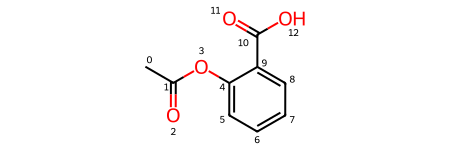

In [18]:
mol = Chem.MolFromSmiles('CC(=O)OC1=CC=CC=C1C(=O)O')
for atom in mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
mol

In [19]:
# 获取结点特征
hg.nodes["atom"].data['feat'].shape

torch.Size([13, 100])

In [20]:
# 获取边特征
hg.edges[('atom', 'interacts', 'atom')].data['feat'].shape

torch.Size([26, 7])

In [21]:
hg.srcdata["feat"]

{'atom': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 'func_group': tensor([[0.6000, 0.0000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.8000, 0.1361,
          0.0000, 0.4000, 0.2000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.2000, 0.4000, 0.0000, 0.4000, 0.0000, 0.0000, 0.8000,
          0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000,
          0.2000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.

In [33]:
task_num=4
batch_size=8
hidden_dim=5

G_h=torch.normal(0,1,(batch_size,hidden_dim))
print(G_h)
print(G_h.unsqueeze(1).repeat(1,3,1).reshape(-1,hidden_dim))

contexts=torch.normal(0,1,(task_num,hidden_dim))
print(contexts)

print(torch.cat((G_h,contexts),dim=-1))

tensor([[-1.9184, -0.5854,  0.6169, -0.1273,  0.0158],
        [ 1.3036, -0.3228, -1.2048, -1.3816, -0.6451],
        [ 0.0702,  0.8945,  0.0912,  0.2012,  0.7812],
        [-0.8382,  0.3265,  1.1191, -1.4371, -1.9788],
        [ 0.7610, -0.1417, -0.2738, -0.2340,  0.7294],
        [-0.3745,  0.4519, -1.0769, -0.9153,  0.2792],
        [-0.6109,  1.6628, -1.0011, -0.1568, -0.3983],
        [-1.3995,  0.1131, -1.5219,  1.5547,  0.9148]])
tensor([[-1.9184, -0.5854,  0.6169, -0.1273,  0.0158],
        [-1.9184, -0.5854,  0.6169, -0.1273,  0.0158],
        [-1.9184, -0.5854,  0.6169, -0.1273,  0.0158],
        [ 1.3036, -0.3228, -1.2048, -1.3816, -0.6451],
        [ 1.3036, -0.3228, -1.2048, -1.3816, -0.6451],
        [ 1.3036, -0.3228, -1.2048, -1.3816, -0.6451],
        [ 0.0702,  0.8945,  0.0912,  0.2012,  0.7812],
        [ 0.0702,  0.8945,  0.0912,  0.2012,  0.7812],
        [ 0.0702,  0.8945,  0.0912,  0.2012,  0.7812],
        [-0.8382,  0.3265,  1.1191, -1.4371, -1.9788],
        [

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 4 for tensor number 1 in the list.